In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from operator import itemgetter
import random
import time
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score, average_precision_score, mean_squared_error
import datetime as dt

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score,  classification_report, confusion_matrix, roc_auc_score

In [2]:
# UČITAVANJE PODATAKA
# -> u ovom modelu koristimo malo drukciji dataset nego u drugim modelima (imamo dodan ID stupac)

X=pd.read_csv('gamma_id.csv')
X['class'] = X['class'].replace(['h', 'g'], [0, 1])
y = X[['ID','class']]
X.head(5)

,ID,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,1,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,2,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,3,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,4,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,5,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [3]:
# PRIPREMA PODATAKA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

test_results = y_test[['ID', 'class']]
target = 'class'
IDcol = 'ID'
train = X_train
test = X_test.drop(['class'], axis = 1)
train.shape, test.shape

((13314, 12), (5706, 11))

In [4]:
train['class'].value_counts()

1    8627
0    4687
Name: class, dtype: int64

In [5]:
# POČETNI MODEL - pogađamo parametre modela, a kasnije ćemo ih prilagođavat
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        silent=0,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [6]:
# XGBoost bez CV - drukčiji je sistem nego kasnije, pa moramo koristiti malo promijenjene varijable
X_train_temp = X_train.drop(['ID','class'], axis=1)
X_test_temp = X_test.drop(['ID','class'], axis=1)

y_train_temp = y_train[['class']]
y_test_temp = y_test[['class']]

xgb1.fit(X_train_temp, y_train_temp.values.ravel(), eval_metric="auc")

y_pred = xgb1.predict(X_test_temp)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_temp.values.ravel(), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.31%


In [7]:
# F1, precision, recall
print(f1_score(y_test_temp, y_pred, average="macro"))
print(precision_score(y_test_temp, y_pred, average="macro"))
print(recall_score(y_test_temp, y_pred, average="macro"))

0.8683027261933833
0.880151921444996
0.8596505391029182


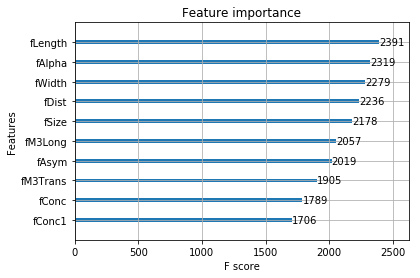

In [8]:
# Feature importance - početni model
plot_importance(xgb1)
pyplot.show()

In [9]:
def plot_roc_curve(fpr, tpr, auc_score):
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.933


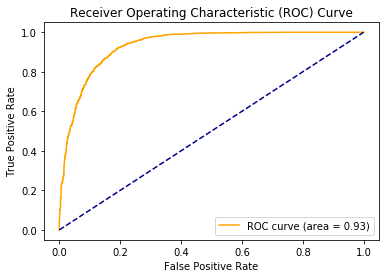

In [10]:
# ROC KRIVULJA ZA BASIC MODEL

probs = xgb1.predict_proba(X_test_temp)
probs = probs[:, 1]
auc = roc_auc_score(y_test_temp, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_test_temp, probs)
plot_roc_curve(fpr, tpr, auc)  

In [11]:
############################################## SADA NADALJE IDE CROSS-VALIDATION ##############################################

In [12]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['class'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['class'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['class'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(results['class'], results['predprob']))

In [13]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [14]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
modelfit(xgb1, train, test, predictors, True, 5, 50)

[0]	train-auc:0.875538+0.00202564	test-auc:0.860358+0.00590167
[1]	train-auc:0.892331+0.00297299	test-auc:0.877728+0.00721579
[2]	train-auc:0.901339+0.00280391	test-auc:0.88894+0.00963363
[3]	train-auc:0.908449+0.00163976	test-auc:0.895213+0.00976876
[4]	train-auc:0.912664+0.00293336	test-auc:0.898537+0.00740477
[5]	train-auc:0.917008+0.00185689	test-auc:0.90253+0.0069074
[6]	train-auc:0.918919+0.00268967	test-auc:0.904166+0.00646426
[7]	train-auc:0.920514+0.002803	test-auc:0.905539+0.00613769
[8]	train-auc:0.921828+0.00332465	test-auc:0.906112+0.00595507
[9]	train-auc:0.92319+0.00347487	test-auc:0.907123+0.00586884
[10]	train-auc:0.924758+0.00275892	test-auc:0.908899+0.00632883
[11]	train-auc:0.926289+0.00248848	test-auc:0.910301+0.00691021
[12]	train-auc:0.927366+0.00228541	test-auc:0.911386+0.00664355
[13]	train-auc:0.927963+0.00224554	test-auc:0.911455+0.00688888
[14]	train-auc:0.9289+0.00209389	test-auc:0.911833+0.00677532
[15]	train-auc:0.929946+0.00189584	test-auc:0.912684+0.007

[129]	train-auc:0.97545+0.000937356	test-auc:0.934203+0.00495645
[130]	train-auc:0.975599+0.000884412	test-auc:0.934254+0.00499396
[131]	train-auc:0.975757+0.00087382	test-auc:0.934214+0.00486675
[132]	train-auc:0.975923+0.00089337	test-auc:0.934201+0.00484008
[133]	train-auc:0.976111+0.000844773	test-auc:0.934226+0.00482015
[134]	train-auc:0.976209+0.00086492	test-auc:0.934218+0.00483237
[135]	train-auc:0.976381+0.00091364	test-auc:0.934199+0.00478608
[136]	train-auc:0.976549+0.000955532	test-auc:0.934165+0.00477953
[137]	train-auc:0.976651+0.000890652	test-auc:0.934187+0.00479423
[138]	train-auc:0.97677+0.000905331	test-auc:0.934222+0.00473278
[139]	train-auc:0.976878+0.00089312	test-auc:0.934232+0.00474432
[140]	train-auc:0.977041+0.000954688	test-auc:0.934336+0.00469105
[141]	train-auc:0.977152+0.000925708	test-auc:0.934326+0.00471223
[142]	train-auc:0.9773+0.00085263	test-auc:0.934397+0.00474957
[143]	train-auc:0.977538+0.000856205	test-auc:0.934456+0.00482408
[144]	train-auc:0.97

[255]	train-auc:0.990048+0.000580884	test-auc:0.935886+0.00444676
[256]	train-auc:0.990156+0.00052522	test-auc:0.935889+0.00444036
[257]	train-auc:0.990225+0.000508328	test-auc:0.935934+0.00440447
[258]	train-auc:0.990276+0.000520777	test-auc:0.935929+0.00437144
[259]	train-auc:0.990322+0.000507675	test-auc:0.935954+0.00434814
[260]	train-auc:0.990386+0.000521884	test-auc:0.935927+0.00439203
[261]	train-auc:0.990482+0.000469165	test-auc:0.935963+0.00440641
[262]	train-auc:0.990561+0.00047398	test-auc:0.935954+0.00441755
[263]	train-auc:0.990649+0.000476728	test-auc:0.935922+0.00440973
[264]	train-auc:0.990712+0.000462644	test-auc:0.935883+0.00444691
[265]	train-auc:0.99077+0.000444337	test-auc:0.93589+0.00448877
[266]	train-auc:0.990838+0.000428681	test-auc:0.935866+0.00445636
[267]	train-auc:0.990857+0.000435703	test-auc:0.935874+0.00445126
[268]	train-auc:0.990933+0.000436403	test-auc:0.935868+0.00443718
[269]	train-auc:0.991024+0.000430283	test-auc:0.935895+0.00439488
[270]	train-au

In [15]:
# Grid search - max_depth i min_child_weight
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=279, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 7, 'min_child_weight': 1}, 0.9365988818424766)

In [16]:
# Grid search - max_depth i min_child_weight
param_test2 = {
    'max_depth':[6,7,8],
    'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=279, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_child_weight': 1}, 0.9365988818424766)

In [17]:
# Grid search - gamma
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=279, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.9365988818424766)

In [18]:
# UPDATE-AMO MODEL S DOBIVENIM OPTIMALNIM VRIJEDNOSTIMA (max_depth = 7, min_child_weight = 1, gamma = 0):
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, train, test, predictors)

[0]	train-auc:0.898611+0.0016842	test-auc:0.878812+0.00777745
[1]	train-auc:0.91499+0.00208705	test-auc:0.892764+0.00710565
[2]	train-auc:0.922746+0.00164436	test-auc:0.901079+0.00757142
[3]	train-auc:0.930287+0.00217266	test-auc:0.907277+0.00842965
[4]	train-auc:0.935042+0.00215875	test-auc:0.910646+0.00571402
[5]	train-auc:0.937888+0.000596279	test-auc:0.912593+0.0061204
[6]	train-auc:0.939699+0.00137036	test-auc:0.913617+0.00595055
[7]	train-auc:0.941476+0.00125896	test-auc:0.914499+0.00601737
[8]	train-auc:0.942815+0.00147833	test-auc:0.915948+0.00503242
[9]	train-auc:0.944462+0.00140558	test-auc:0.91724+0.0058485
[10]	train-auc:0.946394+0.000964324	test-auc:0.919272+0.00636597
[11]	train-auc:0.947932+0.000590265	test-auc:0.920276+0.0068466
[12]	train-auc:0.94958+0.000680663	test-auc:0.921047+0.00670447
[13]	train-auc:0.951044+0.000691394	test-auc:0.92219+0.00667917
[14]	train-auc:0.952058+0.000661679	test-auc:0.922911+0.00641523
[15]	train-auc:0.953249+0.000763061	test-auc:0.92353

[127]	train-auc:0.994801+0.000592148	test-auc:0.936472+0.00457486
[128]	train-auc:0.994925+0.000613804	test-auc:0.936497+0.00461725
[129]	train-auc:0.995002+0.000610674	test-auc:0.936499+0.00459514
[130]	train-auc:0.995108+0.000570208	test-auc:0.936523+0.00461108
[131]	train-auc:0.995193+0.000555065	test-auc:0.936512+0.00460454
[132]	train-auc:0.995298+0.000536655	test-auc:0.936527+0.00464255
[133]	train-auc:0.995435+0.00051814	test-auc:0.936483+0.00462478
[134]	train-auc:0.995495+0.000518925	test-auc:0.936548+0.00453558
[135]	train-auc:0.995641+0.000456096	test-auc:0.936527+0.00451842
[136]	train-auc:0.995736+0.00046048	test-auc:0.936555+0.00447967
[137]	train-auc:0.995812+0.000406376	test-auc:0.936561+0.0045147
[138]	train-auc:0.995905+0.000408293	test-auc:0.936516+0.00453788
[139]	train-auc:0.995968+0.000403516	test-auc:0.936518+0.00460315
[140]	train-auc:0.996049+0.000382466	test-auc:0.93656+0.00455632
[141]	train-auc:0.996128+0.000400143	test-auc:0.936487+0.00455066
[142]	train-au

In [19]:
# Grid search - subsample i colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=238, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9372834877262907)

In [20]:
# Grid search - subsample i colsample_bytree
param_test5 = {
    'subsample':[i/100.0 for i in range(85,100,5)],
    'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=238, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9372834877262907)

In [21]:
# Grid search - reg_alpha
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=238, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9372836112602514)

In [22]:
# Grid search - reg_alpha
param_test7 = {
 'reg_alpha':[0, 0.000005, 0.00001, 0.000015, 0.00002]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=238, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 1.5e-05}, 0.937283982472724)

In [23]:
# Grid search - reg_lambda
param_test8 = {
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=238, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(train[predictors],train[target])
gsearch8.best_params_, gsearch8.best_score_

({'reg_lambda': 1}, 0.9372834877262907)

In [24]:
# Grid search - reg_lambda
param_test9 = {
    'reg_lambda':[0.25, 0.5, 1, 1.5, 1.75]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=238, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch9.fit(train[predictors],train[target])
gsearch9.best_params_, gsearch9.best_score_

({'reg_lambda': 1}, 0.9372834877262907)

In [25]:
# UPDATE-AMO MODEL S DOBIVENIM OPTIMALNIM VRIJEDNOSTIMA 
#(subsample = 0.9, colsample_bytree = 0.6, reg_alpha = 1.5e-05, reg_lambda = 1):

xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha = 1.5e-05,
 reg_lambda = 1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, train, test, predictors)

[0]	train-auc:0.895232+0.0105387	test-auc:0.868137+0.0104553
[1]	train-auc:0.915708+0.00780491	test-auc:0.886926+0.00698308
[2]	train-auc:0.92295+0.00715255	test-auc:0.894712+0.00490679
[3]	train-auc:0.931807+0.00310214	test-auc:0.904081+0.00652943
[4]	train-auc:0.93573+0.00154874	test-auc:0.907642+0.00450817
[5]	train-auc:0.936209+0.00227584	test-auc:0.908216+0.00256927
[6]	train-auc:0.938363+0.00183205	test-auc:0.909893+0.00466578
[7]	train-auc:0.940384+0.00213482	test-auc:0.911478+0.00516354
[8]	train-auc:0.942783+0.0015447	test-auc:0.913526+0.00592217
[9]	train-auc:0.94478+0.0013191	test-auc:0.915064+0.00612168
[10]	train-auc:0.946154+0.00123297	test-auc:0.916651+0.00568863
[11]	train-auc:0.947517+0.00133801	test-auc:0.917416+0.00602309
[12]	train-auc:0.948331+0.00168313	test-auc:0.917834+0.00583831
[13]	train-auc:0.94962+0.000936963	test-auc:0.918743+0.00657971
[14]	train-auc:0.950517+0.00113111	test-auc:0.919596+0.00616676
[15]	train-auc:0.952244+0.00104753	test-auc:0.921025+0.00

[127]	train-auc:0.993944+0.000242186	test-auc:0.934761+0.00413957
[128]	train-auc:0.994071+0.000252388	test-auc:0.934784+0.0041017
[129]	train-auc:0.994176+0.000222176	test-auc:0.934751+0.00413719
[130]	train-auc:0.994253+0.000217094	test-auc:0.934756+0.00413647
[131]	train-auc:0.994301+0.000234685	test-auc:0.93474+0.00410534
[132]	train-auc:0.994347+0.000227176	test-auc:0.934719+0.00408334
[133]	train-auc:0.994492+0.000291146	test-auc:0.934756+0.00404371
[134]	train-auc:0.994556+0.000263771	test-auc:0.934829+0.00406375
[135]	train-auc:0.994666+0.000267581	test-auc:0.934773+0.00409198
[136]	train-auc:0.994762+0.000223424	test-auc:0.934791+0.00402807
[137]	train-auc:0.994828+0.000234241	test-auc:0.934775+0.00398762
[138]	train-auc:0.994908+0.000247152	test-auc:0.934764+0.00400607
[139]	train-auc:0.995+0.000236324	test-auc:0.934752+0.00406667
[140]	train-auc:0.995075+0.000217867	test-auc:0.934796+0.00401244
[141]	train-auc:0.995151+0.000237641	test-auc:0.934764+0.0039855
[142]	train-auc:

In [26]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha = 1.5e-05,
 reg_lambda = 1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, train, test, predictors)

[0]	train-auc:0.895234+0.0105403	test-auc:0.868136+0.0104561
[1]	train-auc:0.914766+0.00773715	test-auc:0.887458+0.00837451
[2]	train-auc:0.921099+0.00752782	test-auc:0.893699+0.00573738
[3]	train-auc:0.929325+0.00331059	test-auc:0.902818+0.00781305
[4]	train-auc:0.933117+0.00163986	test-auc:0.906377+0.0054348
[5]	train-auc:0.933388+0.00215766	test-auc:0.906515+0.00385257
[6]	train-auc:0.93447+0.00209514	test-auc:0.90835+0.00490738
[7]	train-auc:0.935238+0.00279451	test-auc:0.909961+0.00600822
[8]	train-auc:0.936714+0.00194777	test-auc:0.911456+0.00634507
[9]	train-auc:0.937742+0.00173807	test-auc:0.91198+0.00626012
[10]	train-auc:0.938481+0.00158945	test-auc:0.91293+0.00574257
[11]	train-auc:0.939282+0.00136571	test-auc:0.913635+0.00572643
[12]	train-auc:0.939283+0.001338	test-auc:0.913439+0.00533646
[13]	train-auc:0.939666+0.000926419	test-auc:0.91421+0.00653963
[14]	train-auc:0.939825+0.00106635	test-auc:0.914555+0.00575841
[15]	train-auc:0.9407+0.00132575	test-auc:0.916209+0.005860

[128]	train-auc:0.954078+0.000675475	test-auc:0.925465+0.00603114
[129]	train-auc:0.954151+0.00070082	test-auc:0.925538+0.00596934
[130]	train-auc:0.9542+0.000674216	test-auc:0.925576+0.00594642
[131]	train-auc:0.954286+0.000662022	test-auc:0.925621+0.00591035
[132]	train-auc:0.954399+0.000650349	test-auc:0.925656+0.00600046
[133]	train-auc:0.954462+0.000621989	test-auc:0.925653+0.00601865
[134]	train-auc:0.954533+0.000655126	test-auc:0.925739+0.00603463
[135]	train-auc:0.954593+0.000645545	test-auc:0.925728+0.00602194
[136]	train-auc:0.954691+0.000674395	test-auc:0.925794+0.00595318
[137]	train-auc:0.954774+0.000684976	test-auc:0.925853+0.00594187
[138]	train-auc:0.954877+0.000648536	test-auc:0.925882+0.0059661
[139]	train-auc:0.954989+0.000646193	test-auc:0.925979+0.00600322
[140]	train-auc:0.955076+0.000684451	test-auc:0.926018+0.0059255
[141]	train-auc:0.955191+0.00065257	test-auc:0.926096+0.00595983
[142]	train-auc:0.955285+0.000627501	test-auc:0.926144+0.00604955
[143]	train-auc:

[254]	train-auc:0.963908+0.000379346	test-auc:0.929678+0.00554744
[255]	train-auc:0.963996+0.000405069	test-auc:0.929719+0.00553053
[256]	train-auc:0.964078+0.000397961	test-auc:0.929743+0.00551525
[257]	train-auc:0.964134+0.000394009	test-auc:0.929771+0.00551865
[258]	train-auc:0.964224+0.000413388	test-auc:0.929806+0.00550427
[259]	train-auc:0.964294+0.000396474	test-auc:0.929828+0.00548724
[260]	train-auc:0.964375+0.000410007	test-auc:0.929855+0.00545207
[261]	train-auc:0.964431+0.000420535	test-auc:0.929868+0.0054448
[262]	train-auc:0.96451+0.000414758	test-auc:0.929902+0.00544696
[263]	train-auc:0.964579+0.000412439	test-auc:0.929951+0.00545823
[264]	train-auc:0.964638+0.0003983	test-auc:0.929978+0.00545402
[265]	train-auc:0.964713+0.000399465	test-auc:0.930041+0.00547565
[266]	train-auc:0.964791+0.000402186	test-auc:0.930045+0.00550128
[267]	train-auc:0.964846+0.000388852	test-auc:0.930083+0.00550803
[268]	train-auc:0.964941+0.000373108	test-auc:0.930129+0.00551085
[269]	train-au

[379]	train-auc:0.972076+0.000311539	test-auc:0.932298+0.00525358
[380]	train-auc:0.972123+0.000322238	test-auc:0.932308+0.0052309
[381]	train-auc:0.972182+0.000313672	test-auc:0.932338+0.00521715
[382]	train-auc:0.972242+0.000313998	test-auc:0.932366+0.00521776
[383]	train-auc:0.97231+0.000305732	test-auc:0.932379+0.00522714
[384]	train-auc:0.972356+0.000302332	test-auc:0.932379+0.00522335
[385]	train-auc:0.972412+0.000298265	test-auc:0.932397+0.00521064
[386]	train-auc:0.972464+0.000298974	test-auc:0.932399+0.00520908
[387]	train-auc:0.972523+0.000320174	test-auc:0.932411+0.00519995
[388]	train-auc:0.97259+0.000323592	test-auc:0.932429+0.00521956
[389]	train-auc:0.972646+0.000335106	test-auc:0.932433+0.00522118
[390]	train-auc:0.972702+0.000343871	test-auc:0.932437+0.00522262
[391]	train-auc:0.972741+0.00034538	test-auc:0.932438+0.00523191
[392]	train-auc:0.972784+0.000350387	test-auc:0.932468+0.00522693
[393]	train-auc:0.972832+0.000340449	test-auc:0.932484+0.00520463
[394]	train-au

[504]	train-auc:0.978348+0.000551079	test-auc:0.933901+0.00510226
[505]	train-auc:0.97839+0.000552818	test-auc:0.933905+0.00509967
[506]	train-auc:0.978428+0.000542545	test-auc:0.9339+0.00509057
[507]	train-auc:0.978467+0.000541365	test-auc:0.93392+0.00509018
[508]	train-auc:0.978504+0.000544072	test-auc:0.93392+0.00509054
[509]	train-auc:0.978564+0.000532021	test-auc:0.93394+0.00510056
[510]	train-auc:0.978609+0.000537272	test-auc:0.933943+0.00509504
[511]	train-auc:0.978658+0.0005378	test-auc:0.933945+0.00510904
[512]	train-auc:0.978694+0.000529666	test-auc:0.93396+0.00511884
[513]	train-auc:0.978744+0.000529524	test-auc:0.933988+0.00511743
[514]	train-auc:0.978791+0.000521169	test-auc:0.934005+0.00511926
[515]	train-auc:0.978829+0.000523006	test-auc:0.93402+0.00512727
[516]	train-auc:0.978879+0.000525938	test-auc:0.934039+0.00512097
[517]	train-auc:0.978912+0.000526377	test-auc:0.934045+0.00511758
[518]	train-auc:0.978962+0.000525812	test-auc:0.934044+0.00513681
[519]	train-auc:0.97

[630]	train-auc:0.983218+0.000680166	test-auc:0.934984+0.00497526
[631]	train-auc:0.983259+0.000672957	test-auc:0.934993+0.00496782
[632]	train-auc:0.983293+0.000666504	test-auc:0.934989+0.0049508
[633]	train-auc:0.983322+0.000666815	test-auc:0.935001+0.00495324
[634]	train-auc:0.98336+0.00067033	test-auc:0.934998+0.00495704
[635]	train-auc:0.983391+0.00066551	test-auc:0.935016+0.00496029
[636]	train-auc:0.983416+0.000667058	test-auc:0.935027+0.00495149
[637]	train-auc:0.983452+0.000661665	test-auc:0.935029+0.0049653
[638]	train-auc:0.983492+0.000658987	test-auc:0.935039+0.00495497
[639]	train-auc:0.983535+0.00065849	test-auc:0.935042+0.00495644
[640]	train-auc:0.983564+0.000662352	test-auc:0.935038+0.00495265
[641]	train-auc:0.9836+0.000657846	test-auc:0.93505+0.00494491
[642]	train-auc:0.983632+0.00066103	test-auc:0.935046+0.00494372
[643]	train-auc:0.98366+0.000655592	test-auc:0.935043+0.00494357
[644]	train-auc:0.983687+0.000648227	test-auc:0.935042+0.00495536
[645]	train-auc:0.983

[756]	train-auc:0.986844+0.000623652	test-auc:0.935664+0.00493192
[757]	train-auc:0.986877+0.000619538	test-auc:0.935673+0.00493551
[758]	train-auc:0.986898+0.000623307	test-auc:0.935676+0.00493439
[759]	train-auc:0.986914+0.000618672	test-auc:0.935684+0.00493063
[760]	train-auc:0.986937+0.000618179	test-auc:0.935676+0.00493817
[761]	train-auc:0.986956+0.000622139	test-auc:0.935672+0.00493938
[762]	train-auc:0.986978+0.000618942	test-auc:0.935681+0.00493678
[763]	train-auc:0.987001+0.00061831	test-auc:0.935691+0.00493206
[764]	train-auc:0.987025+0.000612592	test-auc:0.935689+0.00493886
[765]	train-auc:0.98704+0.00061338	test-auc:0.935696+0.00494269
[766]	train-auc:0.987067+0.000612112	test-auc:0.9357+0.00493055
[767]	train-auc:0.987084+0.000617069	test-auc:0.935699+0.00492768
[768]	train-auc:0.987114+0.000609287	test-auc:0.935692+0.00493169
[769]	train-auc:0.98714+0.00060991	test-auc:0.935695+0.00494081
[770]	train-auc:0.987173+0.000600386	test-auc:0.935703+0.00493693
[771]	train-auc:0

[881]	train-auc:0.989442+0.000616792	test-auc:0.936106+0.0047811
[882]	train-auc:0.989458+0.000620006	test-auc:0.93611+0.00478317
[883]	train-auc:0.989476+0.000618526	test-auc:0.936123+0.00478625
[884]	train-auc:0.989488+0.000621852	test-auc:0.936122+0.00478771
[885]	train-auc:0.989508+0.000617901	test-auc:0.936128+0.00478212
[886]	train-auc:0.989527+0.000619583	test-auc:0.936125+0.00477069
[887]	train-auc:0.989549+0.000612386	test-auc:0.936117+0.00477372
[888]	train-auc:0.989566+0.000611317	test-auc:0.936122+0.00478174
[889]	train-auc:0.989586+0.000617519	test-auc:0.936121+0.00477653
[890]	train-auc:0.98961+0.000623629	test-auc:0.936121+0.00477121
[891]	train-auc:0.989626+0.00062426	test-auc:0.936127+0.00477366
[892]	train-auc:0.98964+0.000630485	test-auc:0.936124+0.00477749
[893]	train-auc:0.989653+0.000625953	test-auc:0.936128+0.00477105
[894]	train-auc:0.989664+0.000627361	test-auc:0.936128+0.00476992
[895]	train-auc:0.989687+0.00061626	test-auc:0.936133+0.00476014
[896]	train-auc:

[1006]	train-auc:0.991444+0.000573376	test-auc:0.936444+0.00463845
[1007]	train-auc:0.991457+0.000567528	test-auc:0.936443+0.0046407
[1008]	train-auc:0.991475+0.00056621	test-auc:0.936458+0.0046529
[1009]	train-auc:0.991487+0.000570735	test-auc:0.93646+0.00464941
[1010]	train-auc:0.991504+0.000569913	test-auc:0.936463+0.00465658
[1011]	train-auc:0.991517+0.000567285	test-auc:0.936461+0.00465718
[1012]	train-auc:0.991523+0.000568765	test-auc:0.936464+0.00465009
[1013]	train-auc:0.991533+0.000560694	test-auc:0.936462+0.00465248
[1014]	train-auc:0.991548+0.000562074	test-auc:0.936466+0.00465348
[1015]	train-auc:0.991557+0.000559669	test-auc:0.936476+0.00464651
[1016]	train-auc:0.991573+0.000555517	test-auc:0.936467+0.00464863
[1017]	train-auc:0.99159+0.000561608	test-auc:0.936473+0.00464259
[1018]	train-auc:0.991605+0.000562352	test-auc:0.936478+0.00464162
[1019]	train-auc:0.991618+0.000562039	test-auc:0.936485+0.00463223
[1020]	train-auc:0.991629+0.000559221	test-auc:0.936485+0.00462521


[1129]	train-auc:0.993063+0.000442979	test-auc:0.936704+0.00449115
[1130]	train-auc:0.993072+0.000444867	test-auc:0.936702+0.00449576
[1131]	train-auc:0.993081+0.000443923	test-auc:0.936697+0.00450364
[1132]	train-auc:0.9931+0.000440111	test-auc:0.936696+0.00451157
[1133]	train-auc:0.993112+0.000437639	test-auc:0.936695+0.00451017
[1134]	train-auc:0.993124+0.000438259	test-auc:0.936702+0.00451734
[1135]	train-auc:0.993136+0.000438354	test-auc:0.936702+0.00451032
[1136]	train-auc:0.99315+0.000435913	test-auc:0.936707+0.00452288
[1137]	train-auc:0.993162+0.000436759	test-auc:0.936703+0.00450811
[1138]	train-auc:0.993182+0.000437182	test-auc:0.936708+0.00450966
[1139]	train-auc:0.993191+0.000435529	test-auc:0.936714+0.00451179
[1140]	train-auc:0.993211+0.000438854	test-auc:0.936709+0.0045078
[1141]	train-auc:0.99322+0.000443109	test-auc:0.936714+0.00450672
[1142]	train-auc:0.99323+0.000440643	test-auc:0.936713+0.00450297
[1143]	train-auc:0.99324+0.000439014	test-auc:0.936718+0.00449964
[1

[1253]	train-auc:0.994368+0.00040109	test-auc:0.937013+0.00443274
[1254]	train-auc:0.994378+0.000405236	test-auc:0.937021+0.00443781
[1255]	train-auc:0.994386+0.000403779	test-auc:0.937021+0.00442801
[1256]	train-auc:0.994395+0.000405238	test-auc:0.937021+0.00442465
[1257]	train-auc:0.994406+0.000403032	test-auc:0.937033+0.004429
[1258]	train-auc:0.994421+0.000398625	test-auc:0.937022+0.00443274
[1259]	train-auc:0.994428+0.000401852	test-auc:0.937025+0.00443241
[1260]	train-auc:0.994434+0.000404131	test-auc:0.93703+0.00443061
[1261]	train-auc:0.994443+0.000405196	test-auc:0.937035+0.00443522
[1262]	train-auc:0.994455+0.000403801	test-auc:0.937041+0.00443069
[1263]	train-auc:0.994462+0.000403789	test-auc:0.937044+0.00443349
[1264]	train-auc:0.994469+0.000399068	test-auc:0.937047+0.00443195
[1265]	train-auc:0.994479+0.000400683	test-auc:0.937044+0.00442401
[1266]	train-auc:0.994488+0.000400751	test-auc:0.937053+0.00442775
[1267]	train-auc:0.9945+0.00039412	test-auc:0.937064+0.00442693
[1

[1377]	train-auc:0.995456+0.000326941	test-auc:0.937221+0.00440321
[1378]	train-auc:0.995459+0.000327323	test-auc:0.937223+0.00439476
[1379]	train-auc:0.995468+0.000330143	test-auc:0.937228+0.00439165
[1380]	train-auc:0.995475+0.000333283	test-auc:0.93723+0.00438987
[1381]	train-auc:0.995482+0.000331785	test-auc:0.937237+0.00439522
[1382]	train-auc:0.99549+0.000330723	test-auc:0.937237+0.00439432
[1383]	train-auc:0.995496+0.000328242	test-auc:0.937234+0.00439207
[1384]	train-auc:0.995502+0.000327714	test-auc:0.937224+0.00439675
[1385]	train-auc:0.995509+0.000328534	test-auc:0.937224+0.00439375
[1386]	train-auc:0.995518+0.000330011	test-auc:0.937227+0.00438417
[1387]	train-auc:0.995527+0.000328548	test-auc:0.937227+0.00438428
[1388]	train-auc:0.995537+0.000329766	test-auc:0.937228+0.0043891
[1389]	train-auc:0.995545+0.000330036	test-auc:0.93723+0.00439444
[1390]	train-auc:0.995553+0.000330564	test-auc:0.937226+0.0043947
[1391]	train-auc:0.995561+0.000332209	test-auc:0.937219+0.0044071
[

[1501]	train-auc:0.996361+0.000341871	test-auc:0.937344+0.00444123
[1502]	train-auc:0.996367+0.00034057	test-auc:0.937348+0.00443397
[1503]	train-auc:0.996379+0.000336412	test-auc:0.937343+0.00443811
[1504]	train-auc:0.996384+0.000338186	test-auc:0.93735+0.00443868
[1505]	train-auc:0.996391+0.000339845	test-auc:0.93735+0.00442697
[1506]	train-auc:0.996394+0.000339934	test-auc:0.937338+0.00443374
[1507]	train-auc:0.9964+0.000340783	test-auc:0.937336+0.00443236
[1508]	train-auc:0.996407+0.00034278	test-auc:0.937348+0.00442564
[1509]	train-auc:0.996415+0.000346111	test-auc:0.937358+0.00443173
[1510]	train-auc:0.996421+0.000344911	test-auc:0.937352+0.00443589
[1511]	train-auc:0.996432+0.00034416	test-auc:0.937355+0.00443314
[1512]	train-auc:0.996439+0.00034314	test-auc:0.937355+0.00443859
[1513]	train-auc:0.996444+0.000343184	test-auc:0.937355+0.00443571
[1514]	train-auc:0.996451+0.000343717	test-auc:0.937352+0.0044405
[1515]	train-auc:0.996453+0.000343719	test-auc:0.937348+0.00443538
[151

[1625]	train-auc:0.997119+0.000297227	test-auc:0.937448+0.00439354
[1626]	train-auc:0.997124+0.000297186	test-auc:0.937445+0.00439886
[1627]	train-auc:0.997129+0.000296727	test-auc:0.937447+0.0044019
[1628]	train-auc:0.997132+0.000296821	test-auc:0.937452+0.00440009
[1629]	train-auc:0.997136+0.000298413	test-auc:0.937459+0.00440676
[1630]	train-auc:0.997143+0.00030029	test-auc:0.937454+0.00440581
[1631]	train-auc:0.997147+0.000298062	test-auc:0.937454+0.0044089
[1632]	train-auc:0.997151+0.000297925	test-auc:0.937457+0.00440526
[1633]	train-auc:0.997155+0.000298172	test-auc:0.937455+0.00440737
[1634]	train-auc:0.997161+0.000300674	test-auc:0.937453+0.00440832
[1635]	train-auc:0.997168+0.000300311	test-auc:0.937456+0.00440868
[1636]	train-auc:0.997173+0.000299861	test-auc:0.937448+0.00441513
[1637]	train-auc:0.997177+0.000299609	test-auc:0.937448+0.00441737
[1638]	train-auc:0.997181+0.000298939	test-auc:0.937444+0.0044137
[1639]	train-auc:0.997187+0.000297	test-auc:0.937446+0.00441904
[1

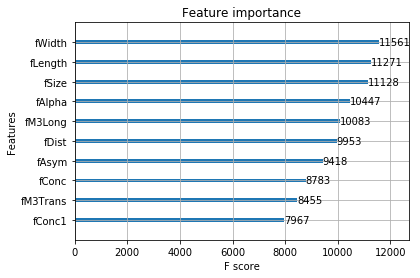

In [27]:
plot_importance(xgb4)
pyplot.show()

AUC: 0.936


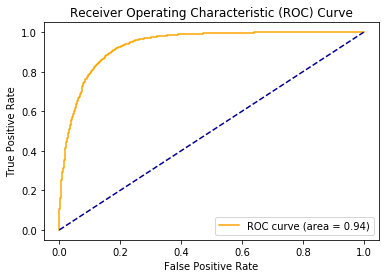

In [28]:
# ROC KRIVULJA ZA OPTIMIZIRANI MODEL

probs = xgb4.predict_proba(X_test_temp)
probs = probs[:, 1]
auc = roc_auc_score(y_test_temp, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_test_temp, probs)
plot_roc_curve(fpr, tpr, auc)

In [29]:
y_pred = xgb4.predict(X_test_temp)
print(f1_score(y_test_temp, y_pred, average="macro"))
print(precision_score(y_test_temp, y_pred, average="macro"))
print(recall_score(y_test_temp, y_pred, average="macro"))

0.8694761398787983
0.8866723049546625
0.8580521480150614
